## Dependencies

This project uses PyTorch and several related libraries for classification using transfer learning. Below is a breakdown of the main imports used:

### Core Libraries

```python
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
````

These are the core PyTorch modules for building and training neural networks.

### Data Handling

```python
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from PIL import Image
```

These are used for loading, preprocessing, and managing image datasets, including custom datasets and built-in transformations.

### Model Utilities

```python
import torchvision.models as models
from torch_lr_finder import LRFinder
from torch.optim.lr_scheduler import ReduceLROnPlateau
```

* `torchvision.models`: Provides pretrained models like VGG,ResNet etc.
* `ReduceLROnPlateau`: Automatically reduces the learning rate when a metric has stopped improving.

### General Utilities

```python
import os
from pathlib import Path
import shutil
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
```

These libraries support file and directory operations, numerical processing, plotting, and progress visualization.

In [1]:
import torch
import torch.utils.data
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import Subset
import multiprocessing
import os
from PIL import Image
import math
import shutil

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torch.autograd import Variable
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import random

In [2]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

## Data Preprocessing

This project uses custom data transformations for training and validation datasets, defined using `torchvision.transforms`. These transformations prepare the input images for a convolutional neural network.

In [3]:
data_transforms = {
        "train": transforms.Compose([
            # Step 1: Resize the image to a consistent size (512, 512 pixels)
            transforms.Resize((512, 512)),
            
            # Step 2: Apply augmentations to make the model more robust
            # Randomly flip the image horizontally (like mirroring it)
            transforms.RandomHorizontalFlip(p=0.5),

            # Randomly rotate the image up to 15 degrees
            transforms.RandomRotation(degrees=15),

            # Randomly change the brightness, you can try: contrast, and saturation
            transforms.ColorJitter(brightness=0.05),
            
            # Step 3: Convert the image to a tensor (a format PyTorch models understand)
            transforms.ToTensor(),
            
            # Step 4: Normalize the image using pre-calculated mean and std for each color channel (RGB)
            # This helps the model learn better by making pixel values roughly between -1 and 1
            transforms.Normalize([0.4429, 0.5322, 0.3367], [0.1901, 0.1883, 0.2020])
    ]),
        "valid": transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor(),
            transforms.Normalize([0.4429, 0.5322, 0.3367], [0.1901, 0.1883, 0.2020])
        ])
}

## Our Entire Data Set `Images(training + testing)` + `Train csv file` + `Test csv file`

In [4]:
data = "/kaggle/input/crop-pestdatasets/Combined_pestDataset"

In [5]:
train = pd.read_csv(data + "/Train.csv")
test = pd.read_csv(data + "/Test.csv")

In [6]:
train["Label"].value_counts()

Label
0    810
1    809
Name: count, dtype: int64

## Dataset Preparation

This section organizes the dataset into a structure suitable for PyTorch's `ImageFolder` or custom dataset loading. The images are divided into training and test directories.

### Directory Structure Created:

```

/kaggle/working/data/
├── train/
│   ├── 0/
│   │   └── image\_001.jpg
│   ├── 1/
│   │   └── image\_002.jpg
│   └── ...
└── test/
├── image\_101.jpg
├── image\_102.jpg
└── ...

````

In [7]:
source_dir = data + '/Images'
output_dir = '/kaggle/working/data'
train_dir = os.path.join(output_dir, 'train')
test_dir = os.path.join(output_dir, 'test')

# Create train class folders
for label in train['Label'].unique():
    os.makedirs(os.path.join(train_dir, str(label)), exist_ok=True)

# Create test folder (no class folders)
os.makedirs(test_dir, exist_ok=True)

# Move train images
for _, row in train.iterrows():
    src = os.path.join(source_dir, row['Image_id'])
    dst = os.path.join(train_dir, str(row['Label']), row['Image_id'])
    if os.path.exists(src):
        shutil.copy2(src, dst)

# Move test images
for _, row in test.iterrows():
    src = os.path.join(source_dir, row['Image_id'])
    dst = os.path.join(test_dir, row['Image_id'])
    if os.path.exists(src):
        shutil.copy2(src, dst)

## Loading the Dataset with `ImageFolder`

The training and validation datasets are loaded using PyTorch’s `ImageFolder`, which expects data organized in subdirectories named by class labels (as previously created).

In [8]:
train_data = datasets.ImageFolder(
        output_dir + "/train",
        transform = data_transforms["train"]
    )
valid_data = datasets.ImageFolder(
        output_dir + "/train",
        transform = data_transforms["valid"]
    )

## Splitting the Dataset: Train/Validation Samplers

To create a proper training/validation split from a single dataset, we randomly partition the indices of the dataset and use PyTorch's `SubsetRandomSampler` to control which samples go into each set.

- Training 80%
- Testing 20%

In [9]:
# obtain training indices that will be used for validation
n_tot = len(train_data)
indices = torch.randperm(n_tot)

limit = -1
valid_size = 0.2

# If requested, limit the number of data points to consider
if limit > 0:
    indices = indices[:limit]
    n_tot = limit

split = int(math.ceil(valid_size * n_tot))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler  = torch.utils.data.SubsetRandomSampler(valid_idx)

## Initializing Data Loaders Dictionary

We initialize a dictionary to store PyTorch `DataLoader` objects for both training and validation phases.

In [10]:
data_loaders = {"train": None, "valid": None}

In [11]:
 # define samplers for obtaining training and validation batches
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
valid_sampler  = torch.utils.data.SubsetRandomSampler(valid_idx)

In [12]:
# Get the number of CPU cores
#The num_workers parameter in DataLoader controls how many subprocesses are used for data loading.
#Using multiple workers allows the system to load and preprocess data in parallel while the GPU is busy training.
num_workers = multiprocessing.cpu_count()
num_workers

4

## Creating Data Loaders

We now create `DataLoader` objects for the training and validation datasets using the batch size and samplers defined earlier.

In [13]:
batch_size = 32 #Number of samples processed in each iteration

# prepare data loaders
data_loaders["train"] = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        sampler=train_sampler,
        num_workers=num_workers,
    )
data_loaders["valid"] = torch.utils.data.DataLoader(
        valid_data,
        batch_size=batch_size,
        sampler=valid_sampler,
        num_workers=num_workers,
    )

## Visualizing images without transforms 

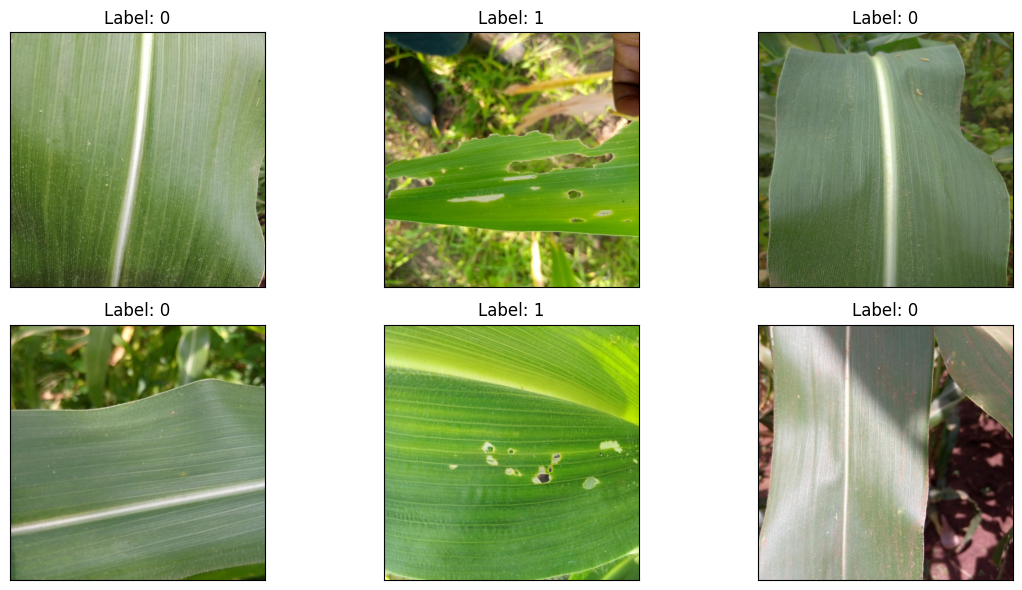

In [14]:
def visualize_one_batch(data_loaders, max_n=6, unnormalize=True):
    """
    Visualizes a batch of images from the 'valid' DataLoader, optionally reversing transforms.

    Args:
    - data_loaders (dict): Dictionary with DataLoader objects (expects 'valid' key).
    - max_n (int): Number of images to show.
    - unnormalize (bool): Whether to undo normalization.
    """

    # One batch from validation set
    dataiter = iter(data_loaders['valid'])
    images, labels = next(dataiter)

    # Inverse normalization for your custom mean/std
    if unnormalize:
        inv_normalize = transforms.Normalize(
            mean=[-m/s for m, s in zip([0.4429, 0.5322, 0.3367], [0.1901, 0.1883, 0.2020])],
            std=[1/s for s in [0.1901, 0.1883, 0.2020]]
        )
        images = torch.stack([inv_normalize(img) for img in images])

    # Plot
    fig = plt.figure(figsize=(12, 6))
    for idx in range(min(max_n, len(images))):
        ax = fig.add_subplot(2, max_n // 2, idx + 1, xticks=[], yticks=[])
        npimg = images[idx].numpy()
        npimg = np.transpose(npimg, (1, 2, 0))
        npimg = np.clip(npimg, 0, 1)  # Clamp to valid range for display
        ax.imshow(npimg)
        ax.set_title(f'Label: {labels[idx].item()}')

    plt.tight_layout()
    plt.show()

#plotting ...
visualize_one_batch(data_loaders)

## Visualizing images with transforms 

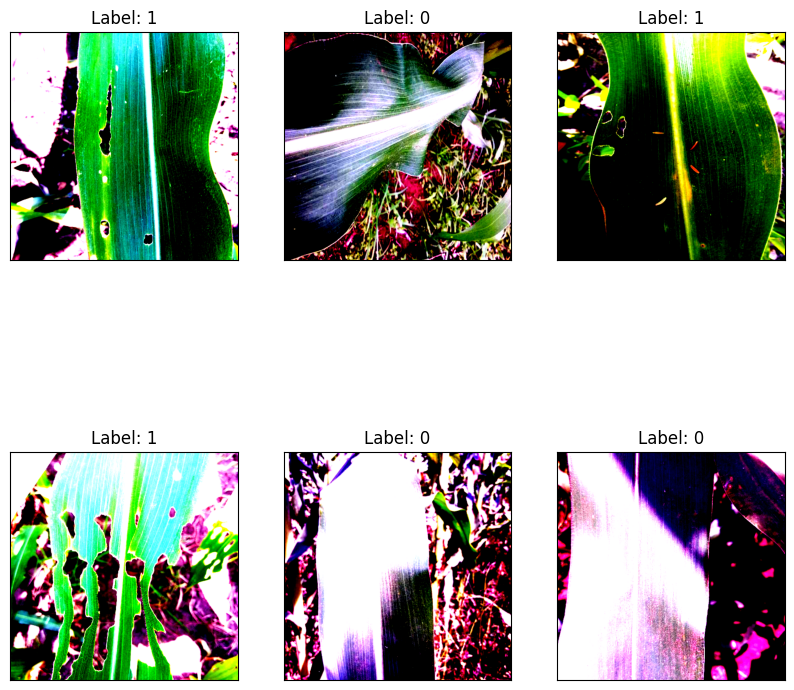

In [15]:
def visualize_one_batch(data_loaders, max_n=6):
    """
    Visualizes a batch of images from the 'train' DataLoader.

    Args:
    - data_loaders (dict): Dictionary containing DataLoader objects for different datasets.
    - max_n (int): Maximum number of images to visualize. Default is 6.
    """
    
    # Check if 'train' DataLoader exists in data_loaders
    if 'train' not in data_loaders:
        raise ValueError("DataLoader for 'train' dataset not found in data_loaders dictionary.")

    # Obtain one batch of training images
    dataiter = iter(data_loaders['valid'])
    images, labels = next(dataiter)

    # Plot images
    fig = plt.figure(figsize=(10, 10))
    for idx in range(max_n):
        ax = fig.add_subplot(2, max_n // 2, idx + 1, xticks=[], yticks=[])
        ax.imshow(np.transpose(images[idx], (1, 2, 0)))
        ax.set_title(f'Label: {labels[idx].item()}')

    plt.show()

#usage
visualize_one_batch(data_loaders)

In [16]:
# Define the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
device

device(type='cuda')

In [18]:
# Define a new network class for transfer learning with ResNet
class TransferNet(nn.Module):
    def __init__(self, n_classes=2):
        super(TransferNet, self).__init__()

        # Load pretrained VGG16
        vgg = models.vgg16(pretrained=True)

        # Freeze all layers
        for param in vgg.parameters():
            param.requires_grad = False

        # Modify the classifier
        num_ftrs = vgg.classifier[6].in_features
        vgg.classifier[6] = nn.Sequential(
                nn.Linear(num_ftrs, 256),   # Reduce dimensionality
                nn.ReLU(),
                nn.Dropout(0.5),
                nn.Linear(256, 64),         # Further reduce
                nn.ReLU(),
                nn.Dropout(0.3),
                nn.Linear(64, n_classes)    # Final output layer for 2 classes
                )

        self.model = vgg  # Assign the full model

    def forward(self, x):
        return self.model(x)

# Define your model and send it to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransferNet(n_classes=2).to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 228MB/s] 


In [19]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1.54e-01) 

# Scheduler setup
scheduler = ReduceLROnPlateau(optimizer, mode="min", verbose=True, threshold=0.01)

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [20]:
"""# Function to plot training curves
def plot_training_curves(train_losses, val_losses, val_accuracies, learning_rates):
    plt.figure(figsize=(15, 5))

    # Plot Losses
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 3, 2)
    plt.plot(val_accuracies, label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy')
    plt.legend()

    # Plot Learning Rate
    plt.subplot(1, 3, 3)
    plt.plot(learning_rates, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Training loop with model saving based on best accuracy and best loss
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_val_acc = 0.0
    best_val_loss = float('inf')
    best_acc_model_weights = None
    best_loss_model_weights = None

    train_losses = []
    val_losses = []
    val_accuracies = []
    learning_rates = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        tqdm_train = tqdm(data_loaders["train"], desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100)
        for inputs, labels in tqdm_train:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            tqdm_train.set_postfix({'Training Loss': running_loss / len(data_loaders["train"].dataset)})

        epoch_train_loss = running_loss / len(data_loaders["train"].dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        tqdm_val = tqdm(data_loaders["valid"], desc="Validating", ncols=100)
        with torch.no_grad():
            for inputs, labels in tqdm_val:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                tqdm_val.set_postfix({'Validation Loss': val_loss / len(data_loaders["valid"].dataset)})

        epoch_val_loss = val_loss / len(data_loaders["valid"].dataset)
        val_losses.append(epoch_val_loss)
        val_acc = correct / total
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Acc: {val_acc:.2%}")

        # Adjust learning rate based on validation loss
        scheduler.step(epoch_val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Save the best models based on validation accuracy and validation loss
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_acc_model_weights = model.state_dict()

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_loss_model_weights = model.state_dict()

        # Plot training curves after each epoch
        plot_training_curves(train_losses, val_losses, val_accuracies, learning_rates)

    # Load the best models based on validation accuracy and validation loss
    if best_acc_model_weights:
        model.load_state_dict(best_acc_model_weights)
        best_model_acc = model

    if best_loss_model_weights:
        model.load_state_dict(best_loss_model_weights)
        best_model_loss = model

    # Return best model and best accuracy
    return best_model_acc, best_val_acc"""

'# Function to plot training curves\ndef plot_training_curves(train_losses, val_losses, val_accuracies, learning_rates):\n    plt.figure(figsize=(15, 5))\n\n    # Plot Losses\n    plt.subplot(1, 3, 1)\n    plt.plot(train_losses, label=\'Train Loss\')\n    plt.plot(val_losses, label=\'Val Loss\')\n    plt.xlabel(\'Epoch\')\n    plt.ylabel(\'Loss\')\n    plt.title(\'Training and Validation Losses\')\n    plt.legend()\n\n    # Plot Accuracy\n    plt.subplot(1, 3, 2)\n    plt.plot(val_accuracies, label=\'Val Accuracy\')\n    plt.xlabel(\'Epoch\')\n    plt.ylabel(\'Accuracy\')\n    plt.title(\'Validation Accuracy\')\n    plt.legend()\n\n    # Plot Learning Rate\n    plt.subplot(1, 3, 3)\n    plt.plot(learning_rates, marker=\'o\')\n    plt.xlabel(\'Epoch\')\n    plt.ylabel(\'Learning Rate\')\n    plt.title(\'Learning Rate Schedule\')\n    plt.grid(True)\n\n    plt.tight_layout()\n    plt.show()\n\n# Training loop with model saving based on best accuracy and best loss\ndef train_model(model, 

In [21]:
from sklearn.metrics import roc_auc_score

# Modified function to plot training curves with AUC
def plot_training_curves(train_losses, val_losses, val_aucs, learning_rates):
    plt.figure(figsize=(15, 5))

    # Plot Losses
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()

    # Plot AUC
    plt.subplot(1, 3, 2)
    plt.plot(val_aucs, label='Val AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('Validation AUC')
    plt.legend()

    # Plot Learning Rate
    plt.subplot(1, 3, 3)
    plt.plot(learning_rates, marker='o')
    plt.xlabel('Epoch')
    plt.ylabel('Learning Rate')
    plt.title('Learning Rate Schedule')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [22]:
# Modified training loop with AUC calculation
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    best_val_auc = 0.0
    best_val_loss = float('inf')
    best_auc_model_weights = None
    best_loss_model_weights = None

    train_losses = []
    val_losses = []
    val_aucs = []
    learning_rates = []

    for epoch in range(num_epochs):
        # Training phase (unchanged)
        model.train()
        running_loss = 0.0
        tqdm_train = tqdm(data_loaders["train"], desc=f"Epoch {epoch+1}/{num_epochs}", ncols=100)
        for inputs, labels in tqdm_train:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            tqdm_train.set_postfix({'Training Loss': running_loss / len(data_loaders["train"].dataset)})

        epoch_train_loss = running_loss / len(data_loaders["train"].dataset)
        train_losses.append(epoch_train_loss)

        # Validation phase (modified for AUC)
        model.eval()
        val_loss = 0.0
        all_probs = []
        all_labels = []

        tqdm_val = tqdm(data_loaders["valid"], desc="Validating", ncols=100)
        with torch.no_grad():
            for inputs, labels in tqdm_val:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                
                # Get probabilities and store them
                probs = torch.softmax(outputs, dim=1)
                all_probs.append(probs.cpu())
                all_labels.append(labels.cpu())
                
                tqdm_val.set_postfix({'Validation Loss': val_loss / len(data_loaders["valid"].dataset)})

        # Calculate AUC
        all_probs = torch.cat(all_probs, dim=0).numpy()
        all_labels = torch.cat(all_labels, dim=0).numpy()
        val_auc = roc_auc_score(all_labels, all_probs[:, 1])

        epoch_val_loss = val_loss / len(data_loaders["valid"].dataset)
        val_losses.append(epoch_val_loss)
        val_aucs.append(val_auc)

        print(f"Epoch [{epoch + 1}/{num_epochs}], "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val AUC: {val_auc:.4f}")

        # Adjust learning rate based on validation loss (unchanged)
        scheduler.step(epoch_val_loss)
        learning_rates.append(optimizer.param_groups[0]['lr'])

        # Save best models based on AUC and loss
        if val_auc > best_val_auc:
            best_val_auc = val_auc
            best_auc_model_weights = model.state_dict()

        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_loss_model_weights = model.state_dict()

        # Plot curves with AUC
        plot_training_curves(train_losses, val_losses, val_aucs, learning_rates)

    # Load best models
    model.load_state_dict(best_auc_model_weights)
    return model, best_val_auc

Epoch 1/5:   0%|                                                             | 0/41 [00:00<?, ?it/s]

Validating:   0%|                                                            | 0/11 [00:00<?, ?it/s]

Epoch [1/5], Train Loss: 86.1169, Val Loss: 0.2176, Val AUC: 0.7625


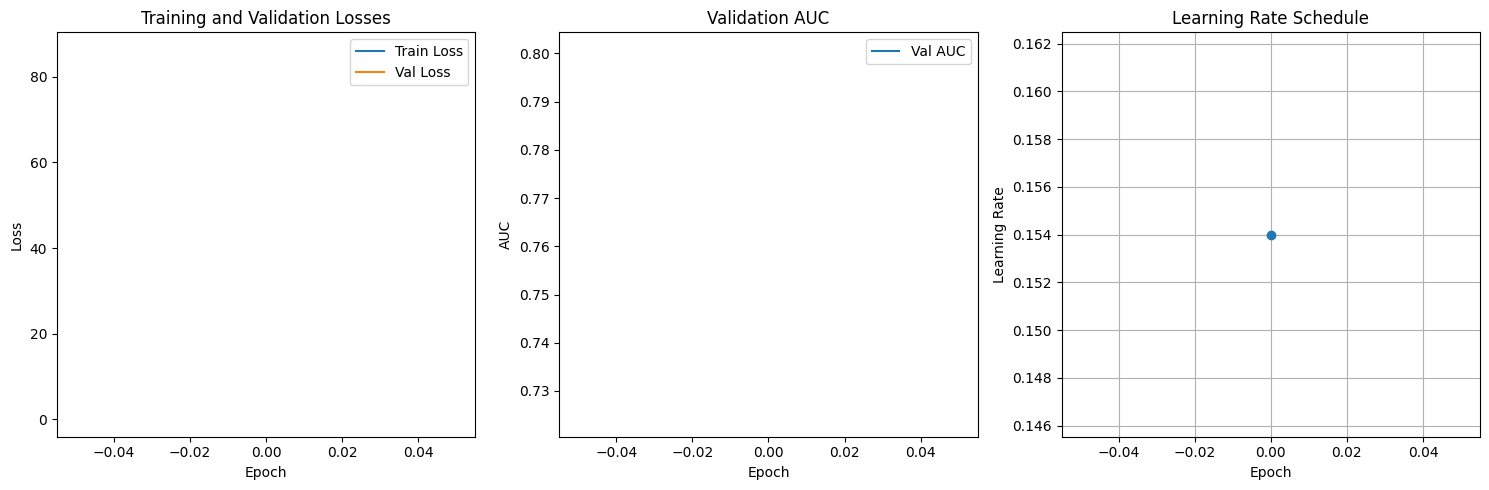

Epoch 2/5:   0%|                                                             | 0/41 [00:00<?, ?it/s]

Validating:   0%|                                                            | 0/11 [00:00<?, ?it/s]

Epoch [2/5], Train Loss: 0.5492, Val Loss: 0.1867, Val AUC: 0.8435


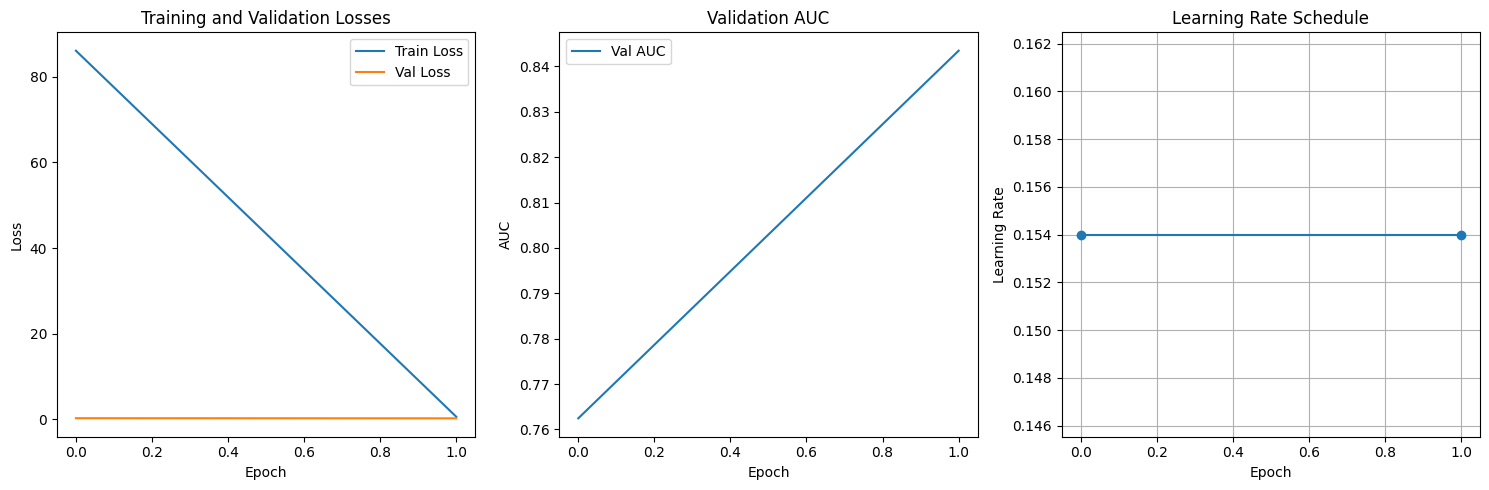

Epoch 3/5:   0%|                                                             | 0/41 [00:00<?, ?it/s]

Validating:   0%|                                                            | 0/11 [00:00<?, ?it/s]

Epoch [3/5], Train Loss: 0.4734, Val Loss: 0.1997, Val AUC: 0.8407


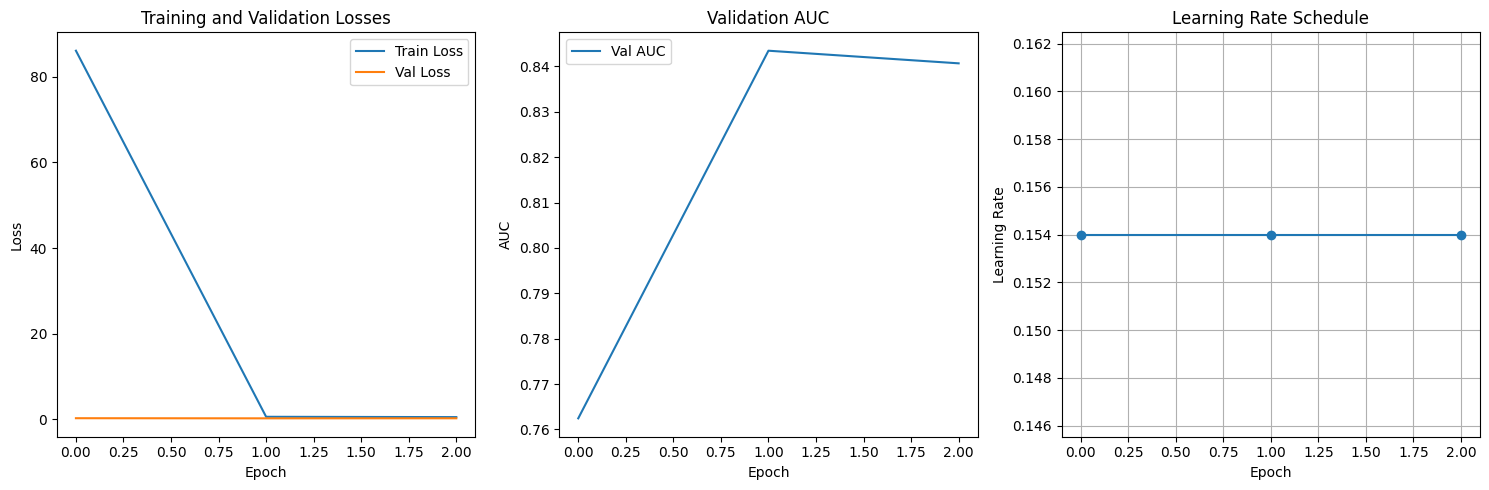

Epoch 4/5:   0%|                                                             | 0/41 [00:00<?, ?it/s]

Validating:   0%|                                                            | 0/11 [00:00<?, ?it/s]

Epoch [4/5], Train Loss: 0.4675, Val Loss: 0.2201, Val AUC: 0.8109


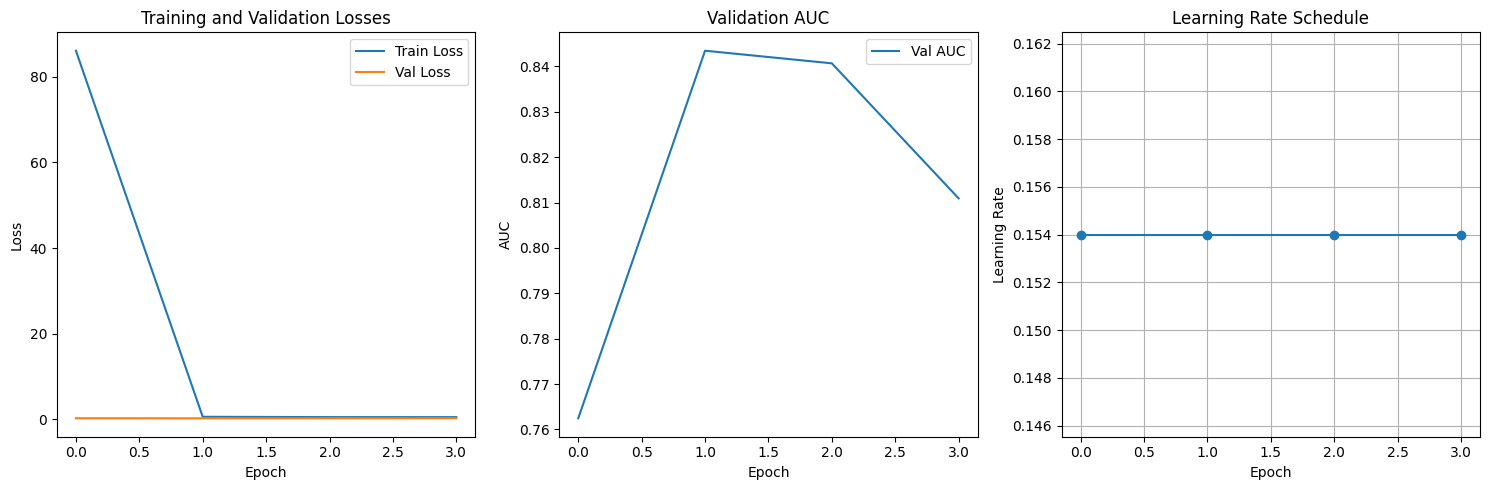

Epoch 5/5:   0%|                                                             | 0/41 [00:00<?, ?it/s]

Validating:   0%|                                                            | 0/11 [00:00<?, ?it/s]

Epoch [5/5], Train Loss: 0.8690, Val Loss: 0.0931, Val AUC: 0.8790


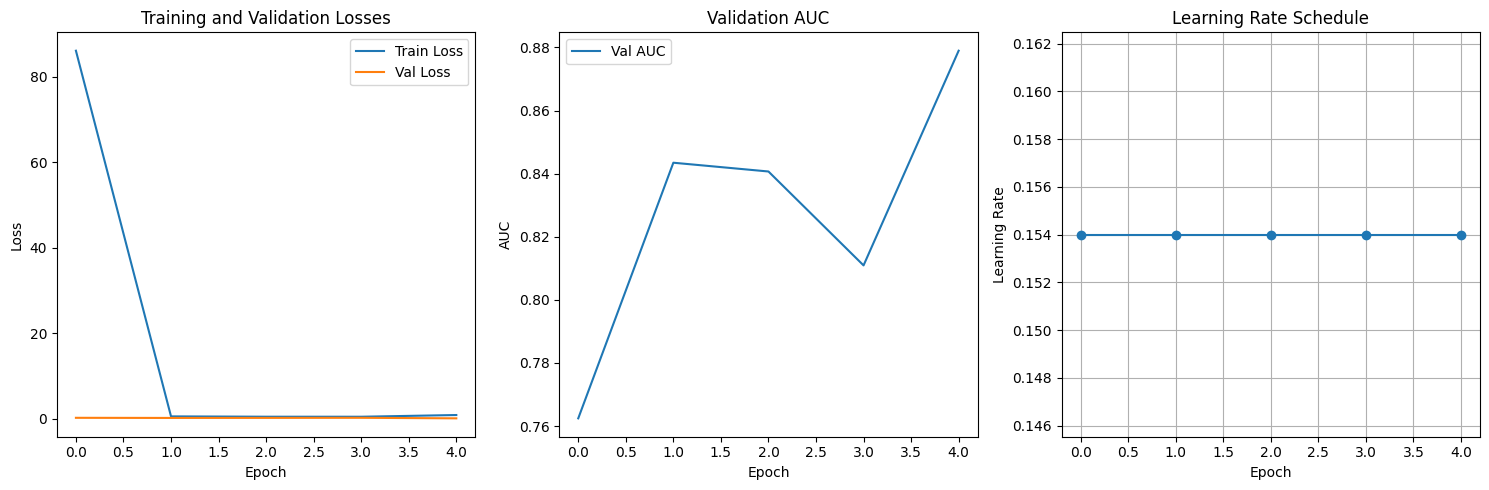

In [23]:
# Example usage:
best_model, best_val_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=5)

# Optionally, save the best model for future use
torch.save(best_model.state_dict(), 'best_model.pth')

### Our Best baseline model accuracy 

In [24]:
best_val_acc

0.8789581983767101

## Running Inference on Test Images

This step loads the trained model and performs inference on all test images, storing only the predicted class labels.


In [25]:
test_dir = output_dir + '/test'
model = best_model

# Define the same transformations used during validation
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4429, 0.5322, 0.3367], std=[0.1901, 0.1883, 0.2020])
])

# Prepare model
model = model.to(device)
model.eval()

# Storage for results
results_class = []

# Loop over all test images
for img_name in os.listdir(test_dir):
    if img_name.endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(test_dir, img_name)
        img = Image.open(img_path).convert('RGB')
        img = transform(img).unsqueeze(0).to(device)

        with torch.no_grad():
            outputs = model(img)
            _, predicted = torch.max(outputs.data, 1)

        # Store image name and predicted class
        results_class.append([img_name, predicted.item()])

# Convert to DataFrame
results_class_df = pd.DataFrame(results_class, columns=['Image_id', 'label'])

# Save predictions to CSV
results_class_df.to_csv('Baseline1.csv', index=False)

In [26]:
results_class_df.head()

,Image_id,label
0,id_emp3f5rkfa2ku.jpg,0
1,id_wpx3pfrqyrk8g.jpg,1
2,id_oldskqcyvb2kl.jpg,1
3,id_4p11omowy0izq.jpg,0
4,id_dfc9c2fim0c66.jpg,1


In [27]:
results_class_df["label"].value_counts()

label
0    658
1    422
Name: count, dtype: int64